In [45]:
import numpy as np      
import pandas as pd     



from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from wordcloud import WordCloud, STOPWORDS

#Visualizations
%matplotlib inline
sns.set_style('whitegrid')
sns.set_context("notebook", font_scale=0.9, rc={"lines.linewidth": 1.8})
import matplotlib.pyplot as plt  
import seaborn as sns

In [59]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # allow multiple outputs in a cell
import warnings
warnings.filterwarnings("ignore")

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.max_colwidth = 6000

### Data Overview

The dataset presented here contains argumentative essays written by U.S students in grades 6-12. These essays were annotated by expert raters for **discourse elements** commonly found in argumentative writing:  

- **Lead** - an introduction that begins with a statistic, a quotation, a description, or some other device to grab the reader’s attention and point toward the thesis
- **Position** - an opinion or conclusion on the main question
- **Claim** - a claim that supports the position
- **Counterclaim** - a claim that refutes another claim or gives an opposing reason to the position
- **Rebuttal** - a claim that refutes a counterclaim
- **Evidence** - ideas or examples that support claims, counterclaims, or rebuttals.
- **Concluding Statement** - a concluding statement that restates the claims

### Train Data 

The training set consist of a .csv file containing the annotated discourse elements each essay, including the quality ratings, together with .txt files containing the full text of each essay. It is important to note that some parts of the essays will be unannotated (i.e., they do not fit into one of the classifications above) and they will lack a quality rating. We do not include the unannotated parts in train.csv.

- **train.csv** - Contains the annotated discourse elements for all essays in the test set.  
    -**discourse_id** - ID code for discourse element  
    -**essay_id** - ID code for essay response. This ID code corresponds to the name of the full-text file in the train/ folder.  
    -**discourse_text** - Text of discourse element.  
    -**discourse_type** - Class label of discourse element.  
    -**discourse_type_num** - Enumerated class label of discourse element .  
    -**discourse_effectiveness** - Quality rating of discourse element, the target.  

## Task I: Load Data 

In [4]:
filepath = '../data/feedback-effectiveness/train.csv'
train_data = pd.read_csv(filepath)
train_data.shape

(36765, 5)

In [5]:
train_data.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform.",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform because there is no life on Mars that we have descovered yet,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The reason why I think it is a natural landform because, nobody live on Mars in order to create the figure. It says in paragraph 9, ""It's not easy to target Cydonia,"" in which he is saying that its not easy to know if it is a natural landform at this point. In all that they're saying, its probably a natural landform.",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by alieans because they thought that there was life on Mars.,Counterclaim,Adequate


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36765 entries, 0 to 36764
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   discourse_id             36765 non-null  object
 1   essay_id                 36765 non-null  object
 2   discourse_text           36765 non-null  object
 3   discourse_type           36765 non-null  object
 4   discourse_effectiveness  36765 non-null  object
dtypes: object(5)
memory usage: 1.4+ MB


In [7]:
train_data.describe()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
count,36765,36765,36765,36765,36765
unique,36765,4191,36691,7,3
top,0013cc385424,91B1F82B2CF1,Summer projects should be student-designed,Evidence,Adequate
freq,1,23,14,12105,20977


In [9]:
train_data.isnull().sum()

discourse_id               0
essay_id                   0
discourse_text             0
discourse_type             0
discourse_effectiveness    0
dtype: int64

### Label and Disclosure Analysis

In [23]:
percentage_discourse = round(100 * train_data['discourse_effectiveness'].value_counts() / train_data.shape[0], 1)
percentage_discourse

Adequate       57.1
Effective      25.4
Ineffective    17.6
Name: discourse_effectiveness, dtype: float64

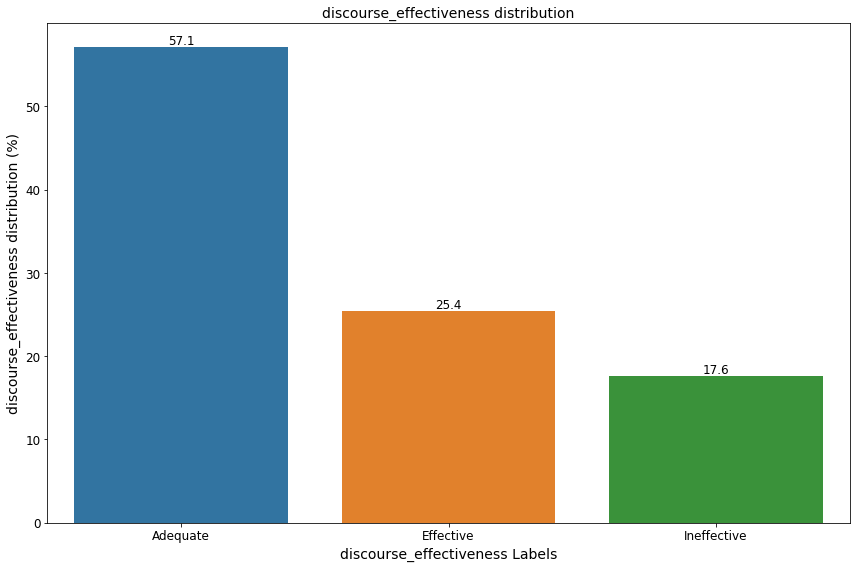

In [24]:
plt.figure(figsize=(12,8))

plt.title('discourse_effectiveness distribution', fontsize = 14)
plt.xlabel('discourse_effectiveness Labels', fontsize = 14)
plt.ylabel('discourse_effectiveness distribution (%)', fontsize = 14)
ax= sns.barplot(percentage_discourse.index, percentage_discourse.values)
for i in ax.containers:
    ax.bar_label(i, fontsize = 12)
    
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout();

### Discourse Type Distribution

In [25]:
 = round(100 * train_data['discourse_type'].value_counts() / train_data.shape[0], 1)
percentage_discourse_type

Evidence                32.9
Claim                   32.6
Position                10.9
Concluding Statement     9.1
Lead                     6.2
Counterclaim             4.8
Rebuttal                 3.4
Name: discourse_type, dtype: float64

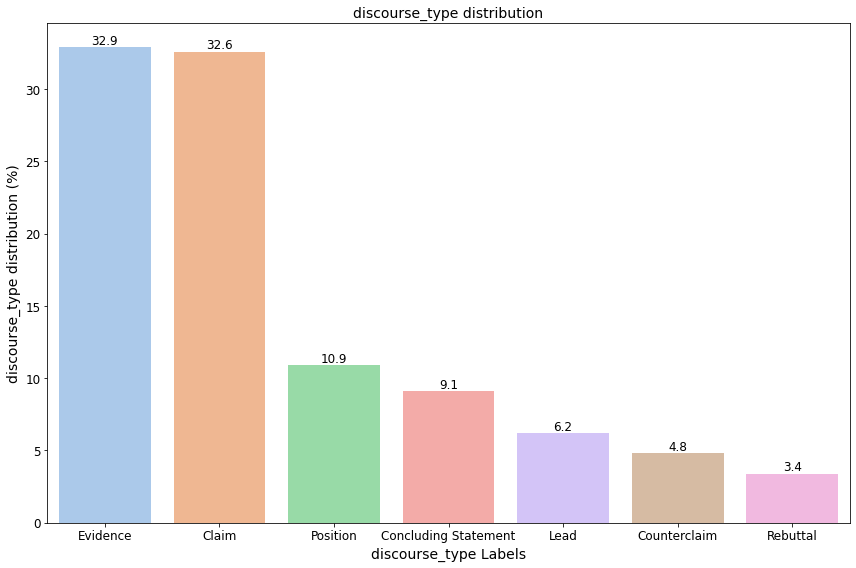

In [28]:
plt.figure(figsize=(12,8))

plt.title('discourse_type distribution', fontsize = 14)
plt.xlabel('discourse_type Labels', fontsize = 14)
plt.ylabel('discourse_type distribution (%)', fontsize = 14)
ax= sns.barplot(percentage_discourse_type.index, percentage_discourse_type.values, palette= 'pastel')
for i in ax.containers:
    ax.bar_label(i, fontsize = 12)
    
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout();

In [42]:
effectiveness_by_type = round((train_data.groupby(['discourse_effectiveness','discourse_type'])['essay_id'].count()/train_data.groupby(['discourse_effectiveness'])['essay_id'].count())*100,2)
effectiveness_by_type = effectiveness_by_type.reset_index()
effectiveness_by_type = effectiveness_by_type.sort_values(by=['discourse_effectiveness','essay_id'], ascending=False)
effectiveness_by_type


,discourse_effectiveness,discourse_type,essay_id
17,Ineffective,Evidence,48.84
14,Ineffective,Claim,22.83
15,Ineffective,Concluding Statement,8.99
19,Ineffective,Position,7.27
18,Ineffective,Lead,5.63
20,Ineffective,Rebuttal,3.27
16,Ineffective,Counterclaim,3.17
7,Effective,Claim,36.51
10,Effective,Evidence,30.94
8,Effective,Concluding Statement,8.85


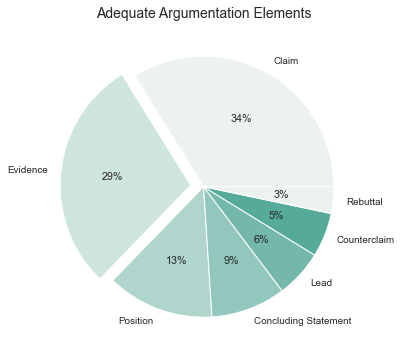

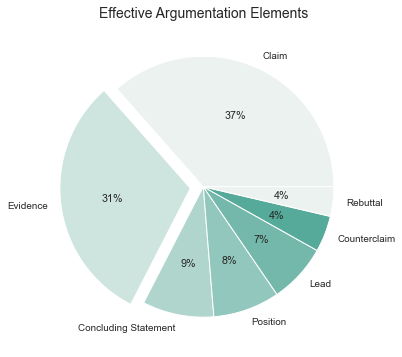

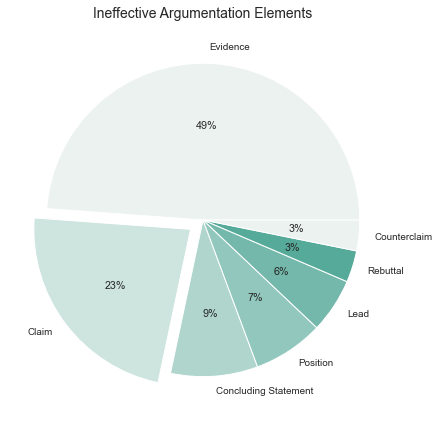

In [85]:


# define Seaborn color palette to use
palette_color = sns.color_palette("light:#5A9")

effective_labels= ['Adequate', 'Effective','Ineffective']
for i in effective_labels:
    # create figure
    fig, ax = plt.subplots(figsize = (12, 6))
    pie_values = list(effectiveness_by_type[effectiveness_by_type.discourse_effectiveness == i]['essay_id'])
    pie_labels = list(effectiveness_by_type[effectiveness_by_type.discourse_effectiveness == i].discourse_type)
    # plotting data on chart
    plt.pie(pie_values,labels=pie_labels,colors=palette_color, autopct='%.0f%%', explode=(0,0.1,0,0,0,0,0))
    plt.title(f'{i} Argumentation Elements', fontsize = 14)  


# displaying chart
plt.tight_layout();

**Claim** stands to be more effective and adequate than **Evidence** provided for the given argument. However, higher **evidence** shows ineffective argument.

### Wordcloud

In [86]:
train_data.head(1)

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform.",Lead,Adequate


In [125]:
STOPWORDS.update(["people", "student", "students", "teacher", "will", "one"])


<Figure size 1368x864 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

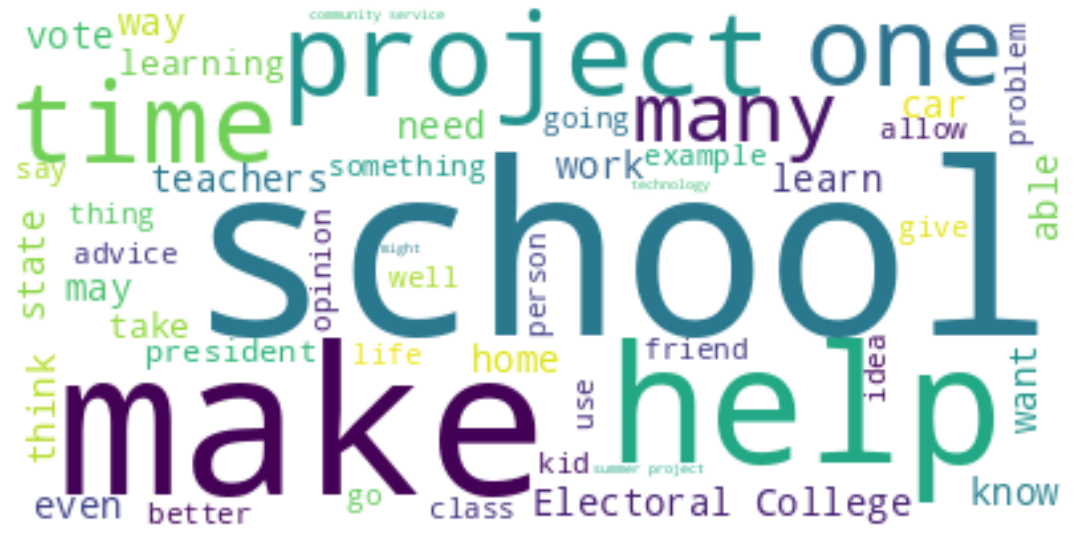

In [126]:
text = " ".join(i for i in train_data[train_data.discourse_effectiveness == 'Effective'].discourse_text)
wordcloud = WordCloud(stopwords=stopwords, background_color="white", normalize_plurals=True,  max_words=50).generate(text)
plt.figure( figsize=(19,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<Figure size 1368x864 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

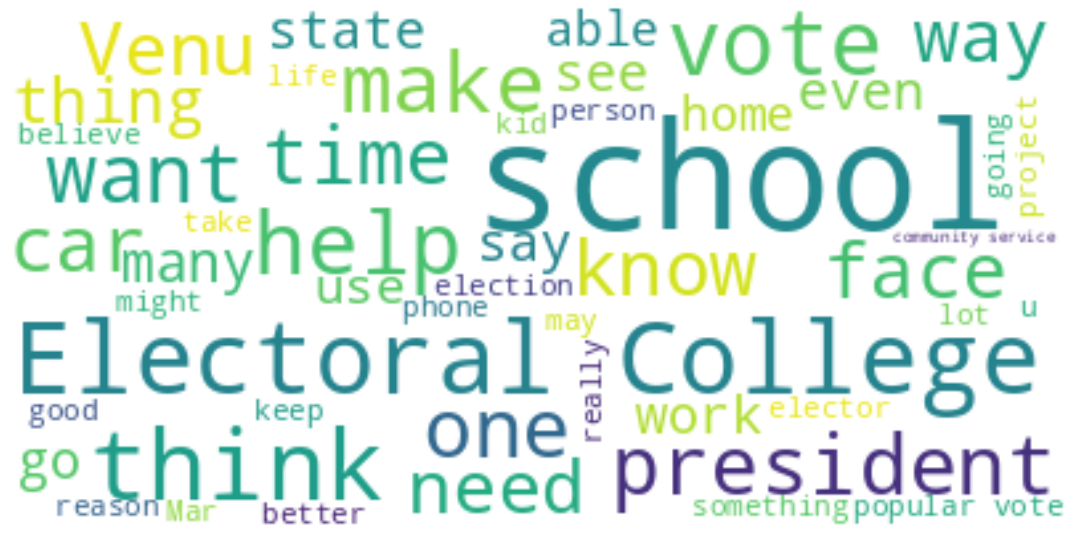

In [127]:
text = " ".join(i for i in train_data[train_data.discourse_effectiveness == 'Adequate'].discourse_text)
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=50, normalize_plurals=True).generate(text)
plt.figure( figsize=(19,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

<Figure size 1368x864 with 0 Axes>

(-0.5, 399.5, 199.5, -0.5)

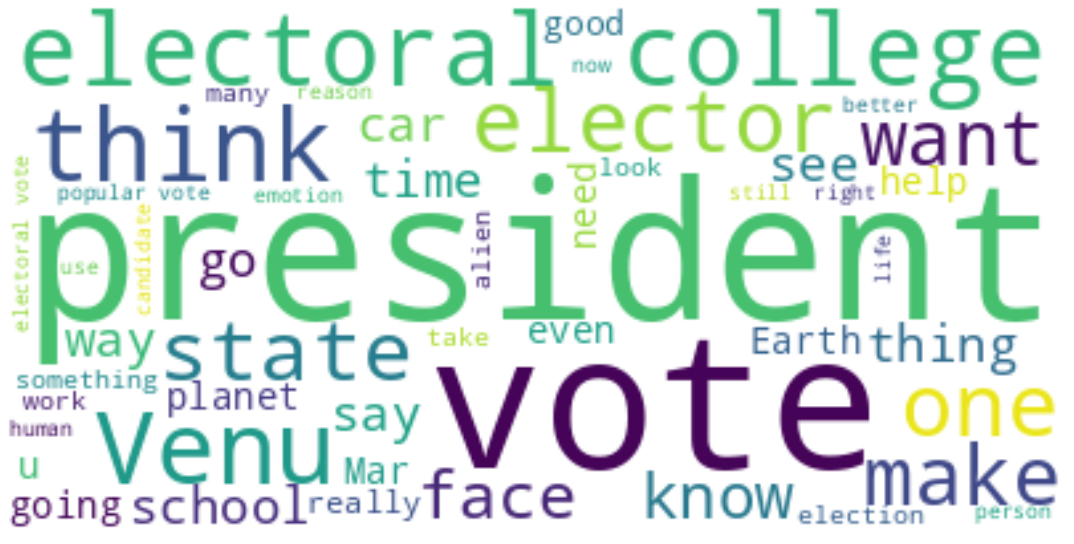

In [128]:
text = " ".join(i for i in train_data[train_data.discourse_effectiveness == 'Ineffective'].discourse_text)
wordcloud = WordCloud(stopwords=stopwords, background_color="white", normalize_plurals=True, max_words=50).generate(text)
plt.figure( figsize=(19,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# normalize_plurals=True